This kernel is about training a 224 x 224 images of diabetic retinopathy images. Since these are images with 224 x 224 size, we'll use Convolutional2d model, in this case we'll use VGG16 as our CNN model with the pretrained weights of imagenet. Firstly, we'll split the input into train and test. We'll use split_folders to do this. However we must first install as this is not a basic python package that's already preinstalled in Kaggle.

In [1]:
!pip install split_folders

In [2]:
import split_folders

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from glob import glob


from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

Using TensorFlow backend.


Then we make our folders for train and validation where the split will be placed.

In [3]:
os.makedirs('output')
os.makedirs('output/train')
os.makedirs('output/val')

Double checking where our input will be...

In [4]:
!ls ../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images

gaussian_filtered_images


And then split the input into train and validation. We'll have a 80-20 split with specified seed to 1 for reproducibility

In [5]:
img_loc = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'

split_folders.ratio(img_loc, output='output', seed=1, ratio=(0.8, 0.2))

Copying files: 3662 files [00:10, 347.01 files/s]


In [6]:
!ls output

train  val


In [7]:
train_loc = 'output/train/'
test_loc = 'output/val/'

Then let's use the ImageDataGenerator to get our train and validation images with their corresponding categories.

In [8]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224),)
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


Load the VGG16 pretrained model with imagenet. Then set the prediction or output layer to 5 outputs which corresponds to 5 different categories -- Severe, No_DR, Moderate, Proliferate_DR, and Mild.

In [9]:
IMAGE_SIZE=[224,224]

In [10]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Imagenet is trained with different kinds of objects. Our images are health related images, which means we must set some of the VGG16 layers to trainable. For this task, I'm using only the 1st Conv2d set as non-trainable to get the edges of our images/focus object. And the rest as trainable.

In [11]:

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-16:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)  

Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


Then we'll use Adam optimiser and use accuracy as our main metric.

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
checkpoint = ModelCheckpoint("vgg16_diabetes.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [14]:
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 4.878378378378378,
 1: 1.8072590738423029,
 2: 1.0,
 3: 6.11864406779661,
 4: 9.376623376623376}

In [15]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy'])


Notice that our non-trainable parameters are just about 260k while trainable parameters are 134M. This was the result of setting trainable layers which we did earlier.

Then we create the checkpoint (which saves the weights when we get the best validation accuracy while training) and early stopping (which stops the training when we reach a certain number of epochs and the validation accuracy is not improving). In our case, we set it to only 20 epochs (denoted by the patience attribute).

To make sure that we have a fair training of our data, we use class weights. We compute this by using Counter to count the number of images per class/category over the number of the supposed max number of images per class/category.

Now that everything's set, let's start training!

Note that we are computing the steps per epoch and the validation steps. This is to get the optimal number of these variables for training our data.

In [16]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=80,callbacks=[checkpoint,early])

Train for 91 steps, validate for 22 steps
Epoch 1/80
90/91 [============================>.] - ETA: 0s - loss: 3.5492 - accuracy: 0.5086
Epoch 00001: val_accuracy improved from -inf to 0.55682, saving model to vgg16_diabetes.h5
91/91 [==============================] - 27s 299ms/step - loss: 3.5412 - accuracy: 0.5088 - val_loss: 3.1629 - val_accuracy: 0.5568
Epoch 2/80
90/91 [============================>.] - ETA: 0s - loss: 2.6294 - accuracy: 0.6754
Epoch 00002: val_accuracy improved from 0.55682 to 0.67614, saving model to vgg16_diabetes.h5
91/91 [==============================] - 21s 233ms/step - loss: 2.6269 - accuracy: 0.6748 - val_loss: 2.8593 - val_accuracy: 0.6761
Epoch 3/80
90/91 [============================>.] - ETA: 0s - loss: 2.2724 - accuracy: 0.7379
Epoch 00003: val_accuracy improved from 0.67614 to 0.69176, saving model to vgg16_diabetes.h5
91/91 [==============================] - 21s 230ms/step - loss: 2.2752 - accuracy: 0.7366 - val_loss: 2.7545 - val_accuracy: 0.6918
E

Epoch 29/80
90/91 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9899
Epoch 00029: val_accuracy did not improve from 0.76847
91/91 [==============================] - 17s 185ms/step - loss: 0.1424 - accuracy: 0.9900 - val_loss: 4.1446 - val_accuracy: 0.7543
Epoch 30/80
90/91 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9899
Epoch 00030: val_accuracy did not improve from 0.76847
91/91 [==============================] - 17s 183ms/step - loss: 0.1434 - accuracy: 0.9900 - val_loss: 4.1947 - val_accuracy: 0.7628
Epoch 31/80
90/91 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9881
Epoch 00031: val_accuracy did not improve from 0.76847
91/91 [==============================] - 17s 184ms/step - loss: 0.1597 - accuracy: 0.9883 - val_loss: 4.1832 - val_accuracy: 0.7358
Epoch 00031: early stopping


Then finally.. let's observe how the model is training. Let's plot our loss vs validation loss as well as accuracy vs validation accuracy.

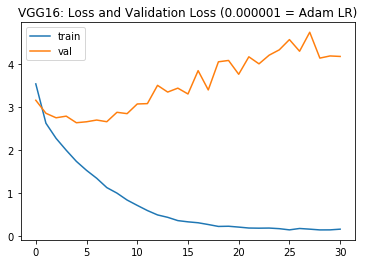

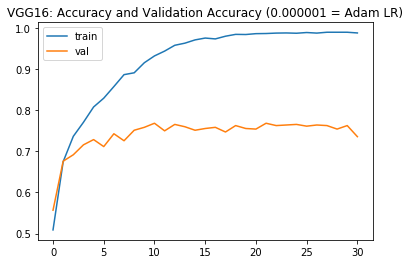

In [17]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

And that's that!

Thanks!